# Preliminary Steps

## Imports

In [1]:
from dotenv import load_dotenv

import os

import traceback

from sql_query_helper_funcs import exec_and_commit_query, sql_query_to_pandas_df

import pandas as pd

from sqlalchemy import create_engine

## Connecting to local db

In [2]:
load_dotenv()

True

In [3]:
db_user = os.environ.get('USER_NAME')
db_pass = os.environ.get('PASS')
db_ip = os.environ.get('IP_ADDRESS')
db_port = os.environ.get('PORT')
db_name = os.environ.get('DB_NAME')

engine = create_engine(f'postgresql+psycopg2://{db_user}:{db_pass}@{db_ip}:{db_port}/{db_name}')

# Loading Data

## Creating staging tables to inspect and clean the data
Create staging tables with generic data types so I can start looking through records in the table

In [4]:
sql_query = """
    DROP TABLE IF EXISTS users_staging;

    CREATE TABLE users_staging (
             userid text,
         subscriber int,
         country text
        );

    DROP TABLE IF EXISTS event_performance_staging;

    CREATE TABLE event_performance_staging (
            userid text,
        event_date text,
              hour int,
            points text
        );
    """

exec_and_commit_query(sql_query, engine)

Query executed and committed.


## Loading dummy data from CSV files into tables

In [5]:
wd = os.getcwd()

sql_query = """ 
COPY users_staging(userid, subscriber, country)
FROM '{working_dir}/data/users.csv'
DELIMITER ','
CSV HEADER;

COPY event_performance_staging(userid, event_date, hour, points)
FROM '{working_dir}/data/event_performance.csv'
DELIMITER ','
CSV HEADER;
""".format(working_dir = wd)

exec_and_commit_query(sql_query, engine)

Query executed and committed.


# Checking for NULL Values

In [6]:
sql_query = """ 
SELECT *
  FROM users_staging
 WHERE userid IS NULL
    OR subscriber IS NULL
    OR country IS NULL;
"""

sql_query_to_pandas_df(sql_query, engine)

,userid,subscriber,country


No Null values were found in the users_staging table.

In [7]:
sql_query = """ 
SELECT *
  FROM event_performance_staging
 WHERE userid IS NULL
    OR event_date IS NULL
    OR hour IS NULL
    OR points IS NULL;
"""

sql_query_to_pandas_df(sql_query, engine)

,userid,event_date,hour,points


No NULL values were found in event_performance_staging either.  As no NULL values exist in either table, there shouldn't be any need to impute values or drop records with missing information.

# Checking for Duplicate Values

In [8]:
sql_query = """ 
  SELECT userid
       , COUNT(userid)
    FROM users_staging
    GROUP BY userid
    HAVING COUNT(userid) > 1;
"""

sql_query_to_pandas_df(sql_query, engine)

,userid,count


No duplicate values found in the users_staging table.

In [9]:
sql_query = """ 
  SELECT userid, event_date, hour, points, COUNT(*)
    FROM event_performance_staging
    GROUP BY userid, event_date, hour, points
    HAVING COUNT(*) > 1;
"""

sql_query_to_pandas_df(sql_query, engine)

,userid,event_date,hour,points,count


No duplicate values found in the event_performance_staging table.

# Cleaning Data

## Cleaning `users_staging`

### `userid`

In [10]:
sql_query = """ 
  SELECT LENGTH(userid) AS userid_length
       , COUNT(*) AS frequency
    FROM users_staging
    GROUP BY LENGTH(userid);
"""

sql_query_to_pandas_df(sql_query, engine)

,userid_length,frequency
0,36,1100


All userids are 36 characters, indicating userids have a standardized length.  Visual inspection shows the userids contain a mixture of alphanumeric characters, so I'll make them VARCHAR(36) when moving the cleaned data to the new table.

### `subscriber`

In [11]:
sql_query = """ 
  SELECT DISTINCT(subscriber::int)
    FROM users_staging;
"""

sql_query_to_pandas_df(sql_query, engine)

,subscriber
0,0
1,1


Because subscriber is a binary variable, I would like it to be the <i>int</i> data type.  It converts to <i>int</i> with no problems and all values in the dataset are either 0 or 1, as they're supposed to be.  Everything looks good here.

### `country`

In [12]:
sql_query = """ 
  SELECT DISTINCT(country)
    FROM users_staging;
"""

sql_query_to_pandas_df(sql_query, engine)

,country
0,US
1,CA
2,MX


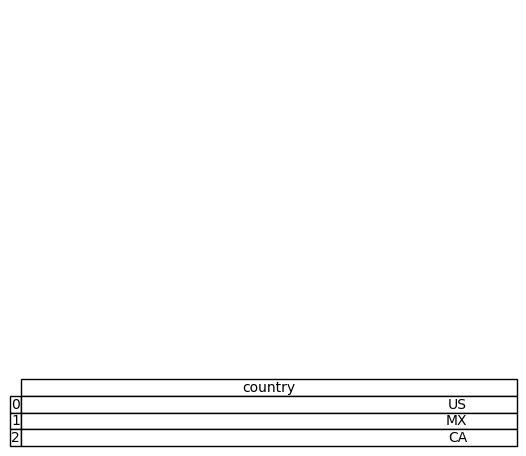

In [32]:
from pandas.plotting import table  # EDIT: see deprecation warnings below
import matplotlib.pyplot as plt

sql_query = """ 
  SELECT DISTINCT(country)
    FROM users_staging;
"""

df = sql_query_to_pandas_df(sql_query, engine)

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, df)  # where df is your data frame

plt.savefig('mytable.png')

Because country is a single character string representing which country a user falls into, I would like it to be the <i>VARCHAR(2)</i> data type since all values in the dataset are either 'US', 'MX', or 'CA'.

## Cleaning `event_performance`

### `userid`

In [13]:
sql_query = """ 
  SELECT LENGTH(userid) AS userid_length
       , COUNT(*) AS frequency
    FROM event_performance_staging
    GROUP BY LENGTH(userid);
"""

sql_query_to_pandas_df(sql_query, engine)

,userid_length,frequency
0,37,2
1,36,37569


It was noted earlier that all userids in the users_staging table had 36 characters, however 2 userids have 37 characters in this table. This has to be a mistake, and I isolate those rows to inspect the userids and figure out why.

In [14]:
def quote(s):
    rep_dict = {' ': '\s'}
    return "".join(rep_dict.get(c, c) for c in s)

In [15]:
sql_query = """ 
  SELECT userid
       , LENGTH(userid) AS userid_length
    FROM event_performance_staging
    WHERE LENGTH(userid) = (SELECT MAX(LENGTH(userid)) 
                              FROM event_performance_staging);
"""

long_userids = sql_query_to_pandas_df(sql_query, engine)

long_userids['userid'] = long_userids['userid'].apply(quote)

long_userids

,userid,userid_length
0,4297f22d-1889-4b5b-80bb-cdaa6a8809bd\s,37
1,"5ddbc2c6-6e9b-4f0b-af64-487074332862""",37


These two entries have a userid that's 37 characters long, while all of the others in both tables have just 36 characters.  The second userid clearly has a quotation mark at the end, however, the problem with the first userid isn't quite as obvious. Close inspection reveals there's a whitespace character at the end of the userid, and I use a function to convert that character to "\s" to make it easier to see. Both of these must be typos and will be removed shortly.

### `event_date`

In [16]:
sql_query = """ 
SELECT event_date::date
  FROM event_performance_staging;
"""

try:
    sql_query_to_pandas_df(sql_query, engine)
except Exception as e:
    traceback.print_exc(limit=1)
    exit(1)

Traceback (most recent call last):
  File "/Users/rancher/miniconda3/envs/ox2/lib/python3.11/site-packages/sqlalchemy/engine/base.py", line 1965, in _exec_single_context
    self.dialect.do_execute(
psycopg2.errors.DatetimeFieldOverflow: date/time field value out of range: "19/24/2019"
HINT:  Perhaps you need a different "datestyle" setting.


The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/var/folders/lp/jgdr2r255gz098q__v2pjv0r0000gn/T/ipykernel_73380/2158672468.py", line 7, in <module>
    sql_query_to_pandas_df(sql_query, engine)
sqlalchemy.exc.DataError: (psycopg2.errors.DatetimeFieldOverflow) date/time field value out of range: "19/24/2019"
HINT:  Perhaps you need a different "datestyle" setting.

[SQL:  
SELECT event_date::date
  FROM event_performance_staging;
]
(Background on this error at: https://sqlalche.me/e/20/9h9h)


The error is caused by one entry in the event_date column that's set to "19/24/2019".  Since there's no way to identify whether this date is meant to be "1/24/2019" or "9/24/2019" or perhaps something else entirely, the safest option is to drop it.  Dropping one entry in a dataset this size shouldn't make much of a difference.

In [17]:
sql_query = """
DELETE FROM event_performance_staging
WHERE event_date = '19/24/2019';
    """

exec_and_commit_query(sql_query, engine)

Query executed and committed.


With that one problematic event_date dropped, I'm going to convert the remaining event_dates to the DATE type and to a more consistent format.  Most event_dates had 2 digit years in the MM/DD/YY format, while some had four digit years in a different format.  Using the to_date function will standardize all event_dates to display the more descriptive four digit years in the YYYY-MM-DD format.

In [18]:
sql_query = """
ALTER TABLE event_performance_staging
	ALTER COLUMN event_date
	TYPE DATE
	USING (to_date(event_date, 'MM/DD/YY'));
    """

exec_and_commit_query(sql_query, engine)

Query executed and committed.


In [19]:
sql_query = """ 
  SELECT event_date AS earliest_dates
    FROM event_performance_staging
ORDER BY event_date
LIMIT 5;
"""

sql_query_to_pandas_df(sql_query, engine)

,earliest_dates
0,1999-03-22
1,2019-01-02
2,2019-01-02
3,2019-01-02
4,2019-01-02


Inspecting the remaining dates, there's one date from 1999, which is before this company was founded.  Because there's no way to know what the true date for this entry is, it will have to be excluded from the analysis.  I'll do that later when moving the cleaned data to the new tables.

In [20]:
sql_query = """ 
  SELECT event_date AS latest_dates
    FROM event_performance_staging
ORDER BY event_date DESC
LIMIT 5;
"""

sql_query_to_pandas_df(sql_query, engine)

,latest_dates
0,2039-08-02
1,2019-12-27
2,2019-12-27
3,2019-12-27
4,2019-12-27


There's also one date from 2039, way into the future.  This date will have to be excluded from the analysis too.  I'll also take care of that later when moving the cleaned data to the new tables.

### `hour`

In [21]:
sql_query = """ 
  SELECT DISTINCT(hour::int)
    FROM event_performance_staging
    ORDER BY 1;
"""

sql_query_to_pandas_df(sql_query, engine)

,hour
0,16
1,17
2,18
3,19
4,20


Because hour represents an hour of the day, I would like to convert it to the int data type in the new table. It converts just fine and the values appear to be using military time, ranging from 16:00-20:00, or 4:00pm-8:00pm.

### `points`

In [22]:
sql_query = """ 
SELECT points::int
  FROM event_performance_staging;
"""

try:
    sql_query_to_pandas_df(sql_query, engine)
except Exception as e:
    traceback.print_exc(limit=1)
    exit(1)

Traceback (most recent call last):
  File "/Users/rancher/miniconda3/envs/ox2/lib/python3.11/site-packages/sqlalchemy/engine/base.py", line 1965, in _exec_single_context
    self.dialect.do_execute(
psycopg2.errors.InvalidTextRepresentation: invalid input syntax for type integer: ""732""


The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/var/folders/lp/jgdr2r255gz098q__v2pjv0r0000gn/T/ipykernel_73380/1302021620.py", line 7, in <module>
    sql_query_to_pandas_df(sql_query, engine)
sqlalchemy.exc.DataError: (psycopg2.errors.InvalidTextRepresentation) invalid input syntax for type integer: ""732""

[SQL:  
SELECT points::int
  FROM event_performance_staging;
]
(Background on this error at: https://sqlalche.me/e/20/9h9h)


In [23]:
sql_query = """ 
SELECT points
FROM event_performance_staging
WHERE points ~ '^.*[^A-Za-z0-9 .-].*$';
"""

sql_query_to_pandas_df(sql_query, engine)

,points
0,"""732"""
1,2006??


A new error arises in the points column.  One of the entries is "732" and because of the quotiation marks, can't be converted to an INT.  Another entry also has a question mark in in that raises an error.  I'll remove these typos in a later step.

## Moving data to new, clean tables

### `users`

Based on what was seen earlier, I plan to set up the following schema for a newly defined users table:
1. userid is meant to be a unique 36 character string.
	* For this reason, I set userid to be a PRIMARY KEY
2. subscriber is an integer that can only take on values of 0 or 1
3. country is a string that only takes on 'CA', 'US', or 'MX' for Canada, United States, and Mexico, respectively

No cleaning was really needed for users data.  The query below simply creates a new table with more explcit data types and introduces constraints to ensure all rows get entered with the correct values.  Once the new table is created, the query then copies the data from users_staging table to the users table.

In [24]:
sql_query = """
DROP TABLE IF EXISTS users;

CREATE TABLE users (
	  userid VARCHAR(36) NOT NULL,
  subscriber int NOT NULL,
  country VARCHAR(2) NOT NULL,
 PRIMARY KEY (userid),
  CONSTRAINT valid_subscriber CHECK (subscriber IN (0, 1)),
  CONSTRAINT valid_country CHECK (country IN ('CA', 'US', 'MX'))
	);

 INSERT INTO users(userid, subscriber, country)
      SELECT userid
           , subscriber
           , country
        FROM users_staging;
    """

exec_and_commit_query(sql_query, engine)

Query executed and committed.


### `event_performance`

Here's the schema for the new event_performance table:
1. userid is a 36 character string.  
	* Note: All userids in this table were 36 characters, 
	except for two that were 37 characters.
	One of these userids had double quotes at the end and the other had
	a space at the end, both of which I assume are typos and are
	fixed upon transferring to the new, clean table.
2. event_date is DATE type, with dates occurring during years
only subsequent to the company's creation and before the analysis was performed.
	* Note: I found one date that occurs in 2039 and
	another from 1999 and end up excluding both in the analysis.
3. hour is an integer between 0 and 23 inclusive
4. points is an integer

This query creates a new table to hold the cleaned events_performance data and defines more explicit data types.  The quotation mark and question mark are removed from `points`, the space and quotation mark are removed from `userid`, and dates prior to the founding of the company, or dates after the analysis was performed are excluded. 

In [25]:
sql_query = """
DROP TABLE IF EXISTS event_performance;

CREATE TABLE event_performance (
	    userid VARCHAR(36) NOT NULL,
	event_date DATE NOT NULL,
	      hour int NOT NULL,
	    points int NOT NULL,
	CONSTRAINT valid_hour CHECK (hour >= 0 AND hour <= 23),
    CONSTRAINT valid_event_date CHECK (event_date <= CURRENT_DATE AND 
                                       event_date >= '2013-01-01')
	);

INSERT INTO event_performance(userid, event_date, hour, points) 
     SELECT REGEXP_REPLACE(userid, '[" ]', '', 'gi')
          , event_date
          , hour
          , REGEXP_REPLACE(points, '["?]', '', 'gi')::int
       FROM event_performance_staging
      WHERE event_date <= '2023-07-13'  --Date isn't from the future
        AND event_date >= '2013-01-01'; --Date is from after
        										   --the company was founded.
    """

exec_and_commit_query(sql_query, engine)

Query executed and committed.


## Exporting cleaned data to backup CSV file

In [26]:
sql_query = """
COPY event_performance TO '{working_dir}/data/clean/event_performance_clean.csv' 
                     WITH DELIMITER ',' 
                      CSV HEADER;
    """.format(working_dir=wd)

exec_and_commit_query(sql_query, engine)

Query executed and committed.


# The End